In [14]:
pip install pandas seaborn


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import torch
import pandas as pd 
import pathlib
import seaborn as sns
import warnings

from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

## Data Import


In [44]:
data = pd.read_csv('archive/HAM10000_metadata.csv')

images_path_1 = 'archive/HAM10000_images_part_1/'
images_path_2 = 'archive/HAM10000_images_part_2/'

# Create a column 'image_path' that points to the actual image
data['image_path'] = data['image_id'].apply(
    lambda x: os.path.join(images_path_1, x + '.jpg')
    if os.path.exists(os.path.join(images_path_1, x + '.jpg'))
    else os.path.join(images_path_2, x + '.jpg')
)
print(data.head())

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                        image_path  
0  archive/HAM10000_images_part_1/ISIC_0027419.jpg  
1  archive/HAM10000_images_part_1/ISIC_0025030.jpg  
2  archive/HAM10000_images_part_1/ISIC_0026769.jpg  
3  archive/HAM10000_images_part_1/ISIC_0025661.jpg  
4  archive/HAM10000_images_part_2/ISIC_0031633.jpg  


In [46]:
class HAM10000ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image paths and labels.
            transform (callable, optional): Transform to be applied to the images.
        """
        self.data = dataframe.reset_index(drop=True)
        # Use the provided transform or default to converting the image to a tensor.
        self.transform = transform if transform is not None else transforms.ToTensor()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data.loc[idx, 'image_path']
        # Open the image and ensure it is in RGB format.
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.data.loc[idx, 'dx']
        return image, label


## Properties of the dataset (MetaData)

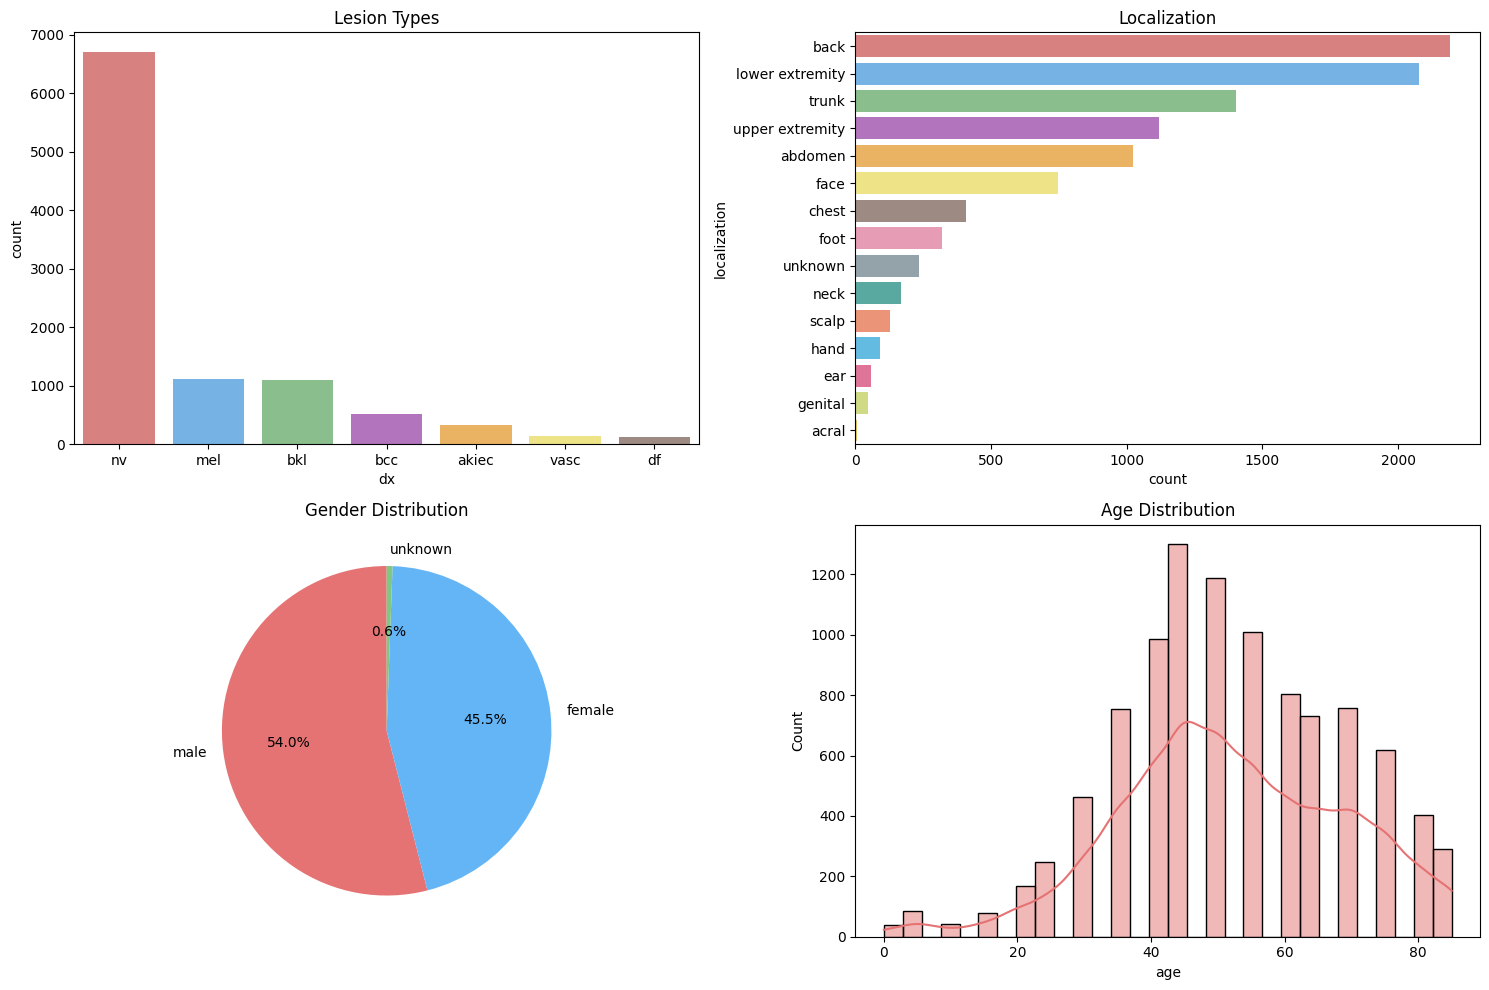

In [45]:
# Some warning popped due to deprecation warning so i just filter them out 
warnings.filterwarnings("ignore", category=FutureWarning)

custom_palette = [
    "#E57373",  # Light Red
    "#64B5F6",  # Light Blue
    "#81C784",  # Light Green
    "#BA68C8",  # Light Purple
    "#FFB74D",  # Light Orange
    "#FFF176",  # Light Yellow
    "#A1887F",  # Soft Brown
    "#F48FB1",  # Soft Pink
    "#90A4AE",  # Gray-Blue
    "#4DB6AC",  # Teal
    "#FF8A65",  # Coral
    "#4FC3F7",  # Sky Blue
    "#F06292",  # Muted Magenta
    "#DCE775",  # Lime
    "#FFD54F"   # Soft Gold
]



fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Count plot for lesion types
sns.countplot(data=data, x='dx', ax=axes[0, 0],palette=custom_palette[:len(data['dx'].unique())],order=data['dx'].value_counts().index)
#--------------------------------------------------------------------------------------------------------------------------------------------
# Count plot for lesion localization
sns.countplot(data=data,y='localization',ax=axes[0, 1],palette=custom_palette[:len(data['localization'].unique())],order=data['localization'].value_counts().index)
#--------------------------------------------------------------------------------------------------------------------------------------------
# Pie chart for gender distribution
gender_counts = data['sex'].value_counts() 
axes[1, 0].pie(gender_counts,labels=gender_counts.index,autopct='%1.1f%%',startangle=90,colors=custom_palette[:len(gender_counts)])
axes[1, 0].set_title('Gender Distribution')
#--------------------------------------------------------------------------------------------------------------------------------------------
# Histogram for age distribution
sns.histplot(data['age'],ax=axes[1, 1],kde=True,bins=30,color=custom_palette[0])


axes[0, 0].set_title('Lesion Types')
axes[0, 1].set_title('Localization')
axes[1, 1].set_title('Age Distribution')
plt.tight_layout()
plt.show()

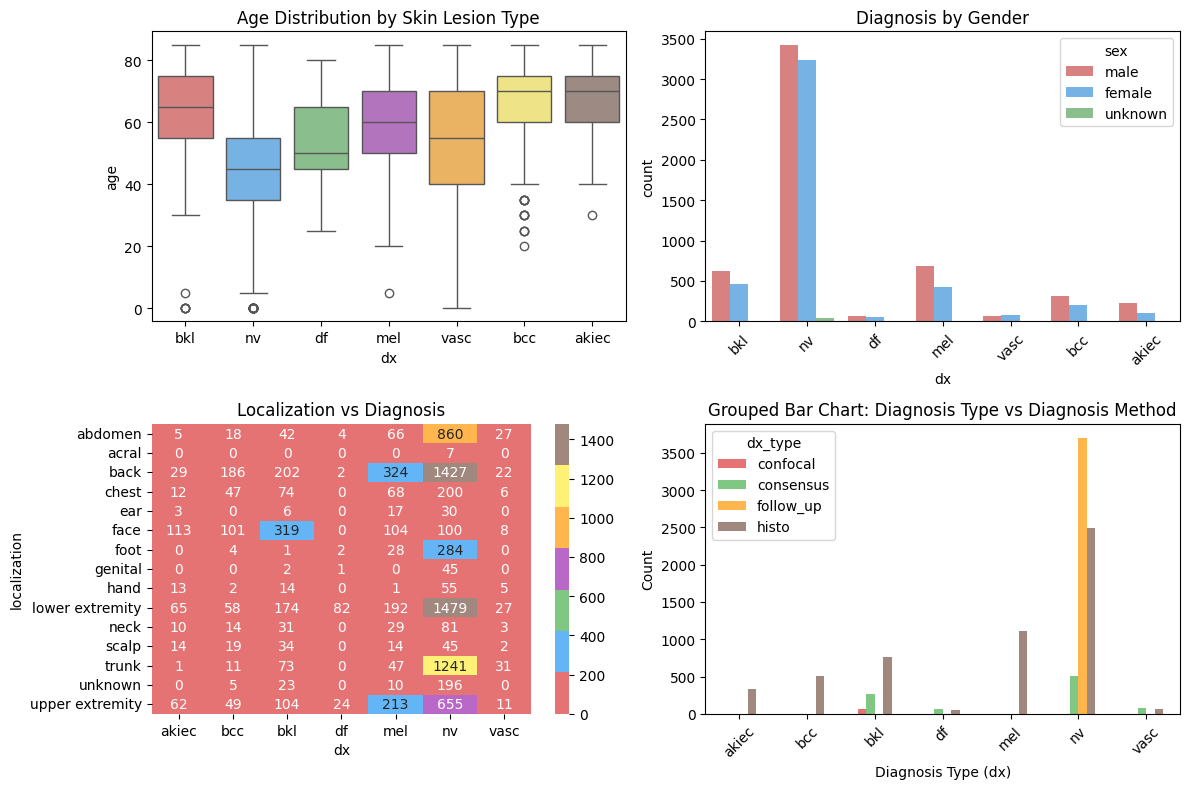

In [41]:
custom_palette = [
    "#E57373",  # Light Red
    "#64B5F6",  # Light Blue
    "#81C784",  # Light Green
    "#BA68C8",  # Light Purple
    "#FFB74D",  # Light Orange
    "#FFF176",  # Light Yellow
    "#A1887F",  # Soft Brown
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First plot: Boxplot for age distribution by skin lesion type
sns.boxplot(x='dx', y='age', data=data, palette=custom_palette, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution by Skin Lesion Type')

# Second plot: Countplot for diagnosis by gender
hue_levels = data['sex'].unique()
palette_countplot = custom_palette[:len(hue_levels)]
sns.countplot(x='dx', hue='sex', data=data, palette=palette_countplot, ax=axes[0, 1])
axes[0, 1].set_title('Diagnosis by Gender')
axes[0, 1].tick_params(axis='x', rotation=45)

# Third plot: Heatmap for localization vs diagnosis with beige and brown palette
cmap = ListedColormap(custom_palette)
sns.heatmap(pd.crosstab(data['localization'], data['dx']), annot=True, fmt="d", cmap=cmap, ax=axes[1, 0])
axes[1, 0].set_title('Localization vs Diagnosis')

# Fourth plot: Bar chart for diagnosis type vs diagnosis method
pivot = data.pivot_table(index='dx', columns='dx_type', aggfunc='size', fill_value=0)
pivot = pivot.reset_index()

pivot.plot(x='dx', kind='bar', figsize=(12, 8), colormap=cmap, ax=axes[1, 1])
axes[1, 1].set_title('Grouped Bar Chart: Diagnosis Type vs Diagnosis Method')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xlabel('Diagnosis Type (dx)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Images sampled

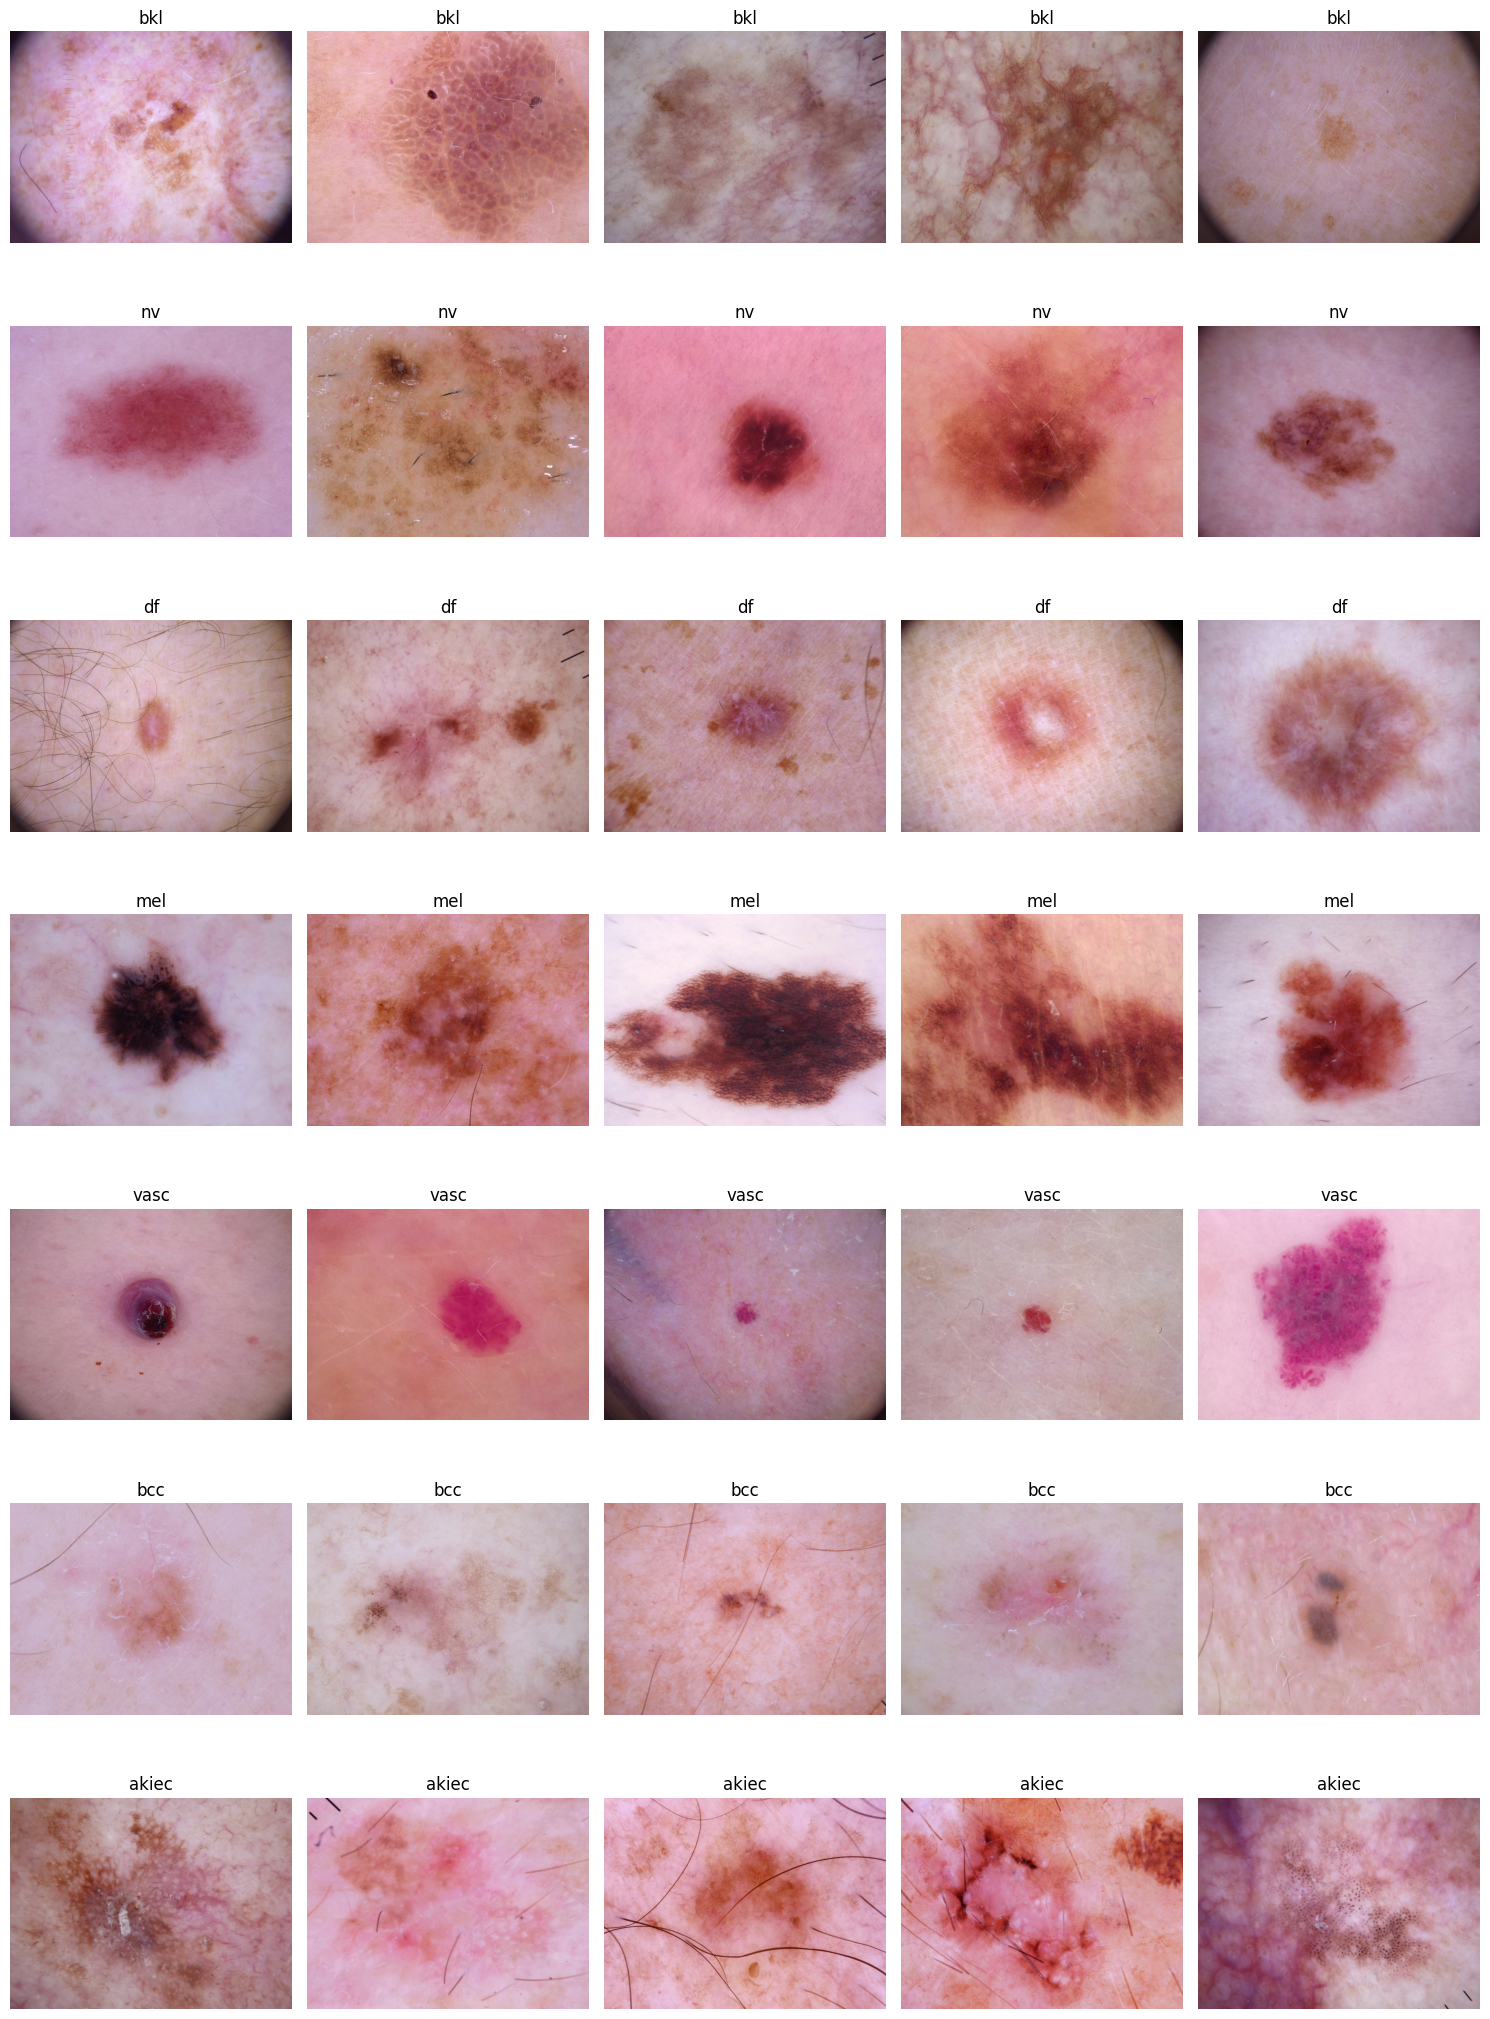

In [47]:
categories = data['dx'].unique()
num_samples = 5


fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 3 * len(categories)))

for i, category in enumerate(categories):
    category_images = data[data['dx'] == category].sample(num_samples)
    for j, image_path in enumerate(category_images['image_path']):
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(category)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

## Mean and standard deviation in the dataset

In [49]:
# Create an instance of the dataset
dataset = HAM10000ImageDataset(data, transform=transforms.ToTensor())

def get_mean_std(dataset, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0
    for images, _ in dataloader:
        batch_samples = images.size(0)
        # Reshape images to (batch, channels, height*width)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    return mean, std

# Compute and print the mean and standard deviation
mean, std = get_mean_std(dataset, batch_size=256)
print('Mean:', mean)
print('Std:', std)

Mean: tensor([0.7635, 0.5461, 0.5705])
Std: tensor([0.0896, 0.1183, 0.1329])
